はじめに、Pythonのライブラリを起動する。

In [ ]:
# 必要なライブラリをインストール
!pip install -U statsmodels
!pip install japanize_matplotlib

In [ ]:
# プログラム3.1
import collections
import math

import cvxpy
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import norm, t
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR
# Colabでファイルを読み込むために、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#####
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15, 6
import japanize_matplotlib

続いて、データを読み込む。最初に読み込むデータは、内閣府が公表しているGDPギャップである。

In [ ]:
# プログラム3.2
# データの読み込み
gap = pd.read_excel("/content/drive/My Drive/data_3.xlsx", sheet_name="GDPギャップ(内閣府)と短観加重平均DI(日本銀行)", header=[0])
caogap = gap.iloc[:, 1]
dti = pd.date_range("1991-03-31", periods=len(gap), freq="QS")

GDPギャップをAR(1)モデルでサンプル外予測する。学習期間は40四半期("PERIOD"で設定)、予測期間は1四半期("H"で設定)とする。また、コードの"L"の値を変えることでARモデルのラグ次数を調整することができる。固定ウィンドウ、拡大ウィンドウ、ローリングウィンドウの各ウィンドウによりサンプル外予測を行うことで、図3.2を作成できる。

In [ ]:
# プログラム3.3
# AR(1)モデルのサンプル外予測
PERIOD = 40  # 訓練データのサンプルサイズ（40四半期）
H = 1  # 予測期間（1四半期）
L = 1  # ARモデルのラグ次数（1四半期）
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(caogap)
nsample = len(data_x)


def train_and_predict_ar_model(train_x, train_y, test_x, test_y):
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    sqe = ((test_y - forecast) ** 2).sum(axis=0)
    return forecast, sqe


# 固定ウィンドウ
predict_result1_list, sqe_result1_list = [], []
predict_result1 = np.zeros((nsample - H) - PERIOD - (L - 1))
sqe_result1 = np.zeros((nsample - H) - PERIOD - (L - 1))
for i in range(0, (nsample - H) - PERIOD - (L - 1), 1):
    train_x = pd.DataFrame()
    test_x = pd.DataFrame()
    for ll in range(1, L + 1, 1):
        # 訓練データの指定
        train_x_lagged = pd.DataFrame(
            np.ravel(
                (data_x[L - ll : L - ll + PERIOD]).to_numpy()
            )
        )
        train_x = pd.concat([train_x, train_x_lagged], axis=1)
        train_y = data_y[0 + H + (L - 1) : 0 + H + PERIOD + (L - 1)]
        # テストデータの指定
        test_x_lagged = pd.DataFrame(
            np.ravel(
                (
                    data_x[i + L - ll + PERIOD : i + L - ll + PERIOD + 1]
                ).to_numpy()
            )
        )
        test_x = pd.concat([test_x, test_x_lagged], axis=1)
        test_y = data_y[
            i + H + PERIOD + (L - 1) : i + H + PERIOD + (L - 1) + 1
        ]
    predict_result1[i], sqe_result1[i] = train_and_predict_ar_model(
        train_x, train_y, test_x, test_y
    )
predict_result1_list.append(predict_result1)
sqe_result1_list.append(sqe_result1)
print(f"固定ウィンドウのMSFE: {np.mean(sqe_result1_list)}")

# 拡大ウィンドウ
predict_result2_list, sqe_result2_list = [], []
predict_result2 = np.zeros((nsample - H) - PERIOD - (L - 1))
sqe_result2 = np.zeros((nsample - H) - PERIOD - (L - 1))
for i in range(0, (nsample - H) - PERIOD - (L - 1), 1):
    train_x = pd.DataFrame()
    test_x = pd.DataFrame()
    for ll in range(1, L + 1, 1):
        # 訓練データの指定
        train_x_lagged = pd.DataFrame(
            np.ravel(
                (
                    data_x[L - ll : i + L - ll + PERIOD]
                ).to_numpy()
            )
        )
        train_x = pd.concat([train_x, train_x_lagged], axis=1)
        train_y = data_y[0 + H + (L - 1) : i + H + PERIOD + (L - 1)]
        # テストデータの指定
        test_x_lagged = pd.DataFrame(
            np.ravel(
                (
                    data_x[i + L - ll + PERIOD : i + L - ll + PERIOD + 1]
                ).to_numpy()
            )
        )
        test_x = pd.concat([test_x, test_x_lagged], axis=1)
        test_y = data_y[
            i + H + PERIOD + (L - 1) : i + H + PERIOD + (L - 1) + 1
        ]
    predict_result2[i], sqe_result2[i] = train_and_predict_ar_model(
        train_x, train_y, test_x, test_y
    )
predict_result2_list.append(predict_result2)
sqe_result2_list.append(sqe_result2)
print(f"拡大ウィンドウのMSFE: {np.mean(sqe_result2_list)}")

# ローリングウィンドウ
predict_result3_list, sqe_result3_list = [], []
predict_result3 = np.zeros((nsample - H) - PERIOD - (L - 1))
sqe_result3 = np.zeros((nsample - H) - PERIOD - (L - 1))
for i in range(0, (nsample - H) - PERIOD - (L - 1), 1):
    train_x = pd.DataFrame()
    test_x = pd.DataFrame()
    for ll in range(1, L + 1, 1):
        # 訓練データの指定
        train_x_lagged = pd.DataFrame(
            np.ravel(
                (
                    data_x[i + L - ll : i + L - ll + PERIOD]
                ).to_numpy()
            )
        )
        train_x = pd.concat([train_x, train_x_lagged], axis=1)
        train_y = data_y[i + H + (L - 1) : i + H + PERIOD + (L - 1)]
        # テストデータの指定
        test_x_lagged = pd.DataFrame(
            np.ravel(
                (
                    data_x[i + L - ll + PERIOD : i + L - ll + PERIOD + 1]
                ).to_numpy()
            )
        )
        test_x = pd.concat([test_x, test_x_lagged], axis=1)
        test_y = data_y[
            i + H + PERIOD + (L - 1) : i + H + PERIOD + (L - 1) + 1
        ]
    predict_result3[i], sqe_result3[i] = train_and_predict_ar_model(
        train_x, train_y, test_x, test_y
    )
predict_result3_list.append(predict_result3)
sqe_result3_list.append(sqe_result3)
print(f"ローリングウィンドウのMSFE: {np.mean(sqe_result3_list)}")

固定ウィンドウのMSFE: 1.9253443950003313
拡大ウィンドウのMSFE: 1.97651327358338
ローリングウィンドウのMSFE: 2.3274893086789317


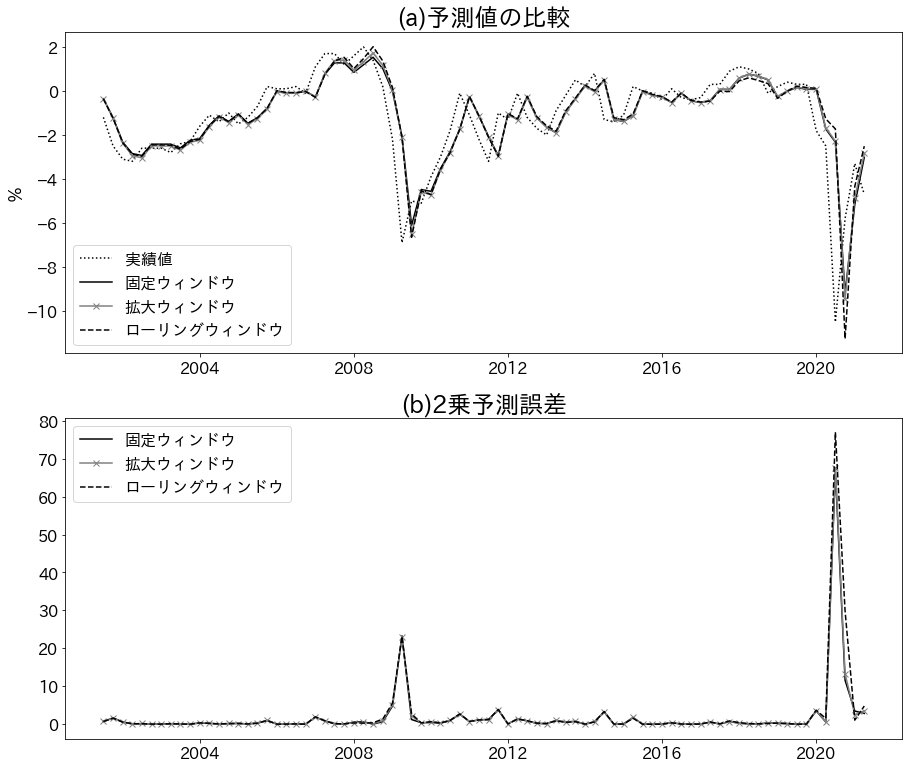

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)予測値の比較", fontsize=24)
ax1.plot(dti[H + PERIOD :], caogap[H + PERIOD :].to_numpy(), label="実績値", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result1_list), label="固定ウィンドウ", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result2_list), label="拡大ウィンドウ", color="grey", marker="x")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result3_list), label="ローリングウィンドウ", color="black", linestyle="dashed")
ax1.legend(loc="lower left", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)2乗予測誤差", fontsize=24)
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result1_list), label="固定ウィンドウ", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result2_list), label="拡大ウィンドウ", color="grey", marker="x")
ax2.plot(dti[H + PERIOD :], np.ravel(sqe_result3_list), label="ローリングウィンドウ", color="black", linestyle="dashed")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)

ウィンドウを選択してください(固定、拡大、ローリングのいずれか): 拡大


(0.0, 5.0)

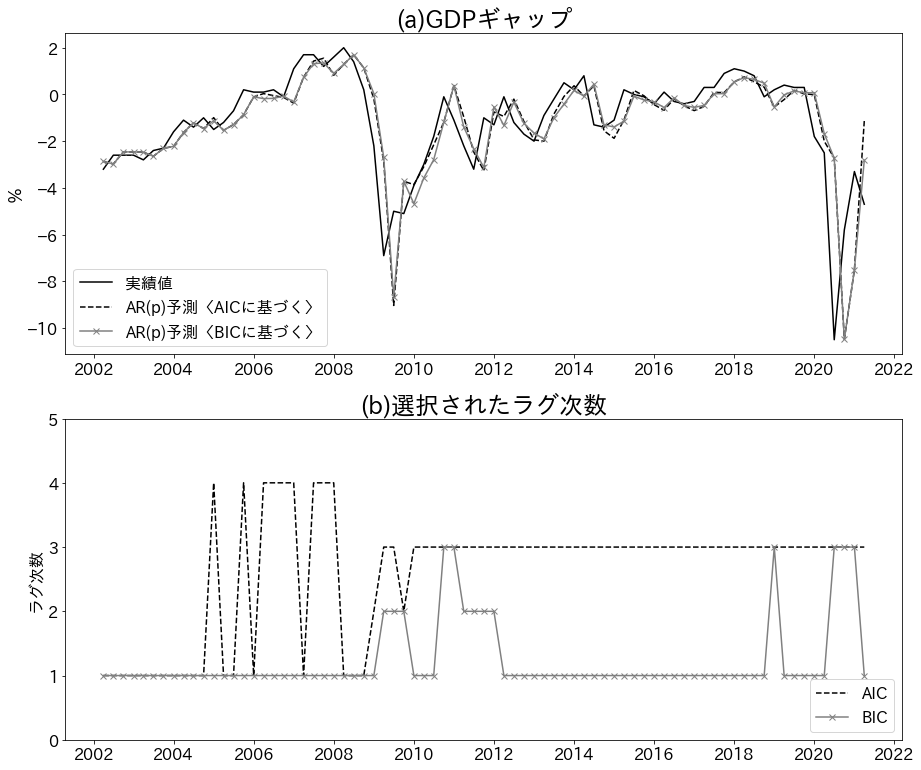

In [ ]:
#####
# AR(p)モデルによるサンプル外予測
scheme = str(input("ウィンドウを選択してください(固定、拡大、ローリングのいずれか): "))
predict_result_list, sqe_result_list, aic_result_list, bic_result_list = [], [], [], []
PERIOD = 40  # 訓練データのサンプルサイズ（40四半期）
H = 1  # 予測期間（1四半期）
MAX_L = 4  # ARモデルの最大ラグ次数（4四半期）
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(caogap)
nsample = len(data_x)

for l in range(1, MAX_L + 1):
    predict_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    sqe_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    aic_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    bic_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    for i in range(0, (nsample - H) - PERIOD - (MAX_L - 1)):
        train_x = pd.DataFrame()
        test_x = pd.DataFrame()
        for ll in range(1, l + 1, 1):
            if scheme == "固定":
                # 訓練データの指定
                train_x_lagged = pd.DataFrame(
                    np.ravel(
                        (data_x.shift(-MAX_L + l)[l - ll : l - ll + PERIOD]).to_numpy()
                    )
                )
                train_x = pd.concat([train_x, train_x_lagged], axis=1)
                train_y = data_y[0 + H + (MAX_L - 1) : 0 + H + PERIOD + (MAX_L - 1)]
                # テストデータの指定
                test_x_lagged = pd.DataFrame(
                    np.ravel(
                        (
                            data_x.shift(-MAX_L + l)[
                                i + l - ll + PERIOD : i + l - ll + PERIOD + 1
                            ]
                        ).to_numpy()
                    )
                )
                test_x = pd.concat([test_x, test_x_lagged], axis=1)
                test_y = data_y[
                    i + H + PERIOD + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1) + 1
                ]
            elif scheme == "拡大":
                # 訓練データの指定
                train_x_lagged = pd.DataFrame(
                    np.ravel(
                        (
                            data_x.shift(-MAX_L + l)[l - ll : i + l - ll + PERIOD]
                        ).to_numpy()
                    )
                )
                train_x = pd.concat([train_x, train_x_lagged], axis=1)
                train_y = data_y[0 + H + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1)]
                # テストデータの指定
                test_x_lagged = pd.DataFrame(
                    np.ravel(
                        (
                            data_x.shift(-MAX_L + l)[
                                i + l - ll + PERIOD : i + l - ll + PERIOD + 1
                            ]
                        ).to_numpy()
                    )
                )
                test_x = pd.concat([test_x, test_x_lagged], axis=1)
                test_y = data_y[
                    i + H + PERIOD + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1) + 1
                ]
            elif scheme == "ローリング":
                # 訓練データの指定
                train_x_lagged = pd.DataFrame(
                    np.ravel(
                        (
                            data_x.shift(-MAX_L + l)[i + l - ll : i + l - ll + PERIOD]
                        ).to_numpy()
                    )
                )
                train_x = pd.concat([train_x, train_x_lagged], axis=1)
                train_y = data_y[i + H + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1)]
                # テストデータの指定
                test_x_lagged = pd.DataFrame(
                    np.ravel(
                        (
                            data_x.shift(-MAX_L + l)[
                                i + l - ll + PERIOD : i + l - ll + PERIOD + 1
                            ]
                        ).to_numpy()
                    )
                )
                test_x = pd.concat([test_x, test_x_lagged], axis=1)
                test_y = data_y[
                    i + H + PERIOD + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1) + 1
                ]
        # モデル推定
        model = LinearRegression()
        model.fit(train_x, train_y)
        y_hat = model.predict(train_x)
        sse = ((train_y - y_hat) ** 2).sum(axis=0)
        aic = math.log(sse / len(train_y)) + (l + 1) * 2 / len(train_y)
        bic = math.log(sse / len(train_y)) + (l + 1) * math.log(len(train_y)) / len(
            train_y
        )
        forecast = model.predict(test_x)
        sqe = ((test_y - forecast) ** 2).sum(axis=0)
        aic_result[i], bic_result[i], predict_result[i], sqe_result[i] = aic, bic, forecast, sqe

    predict_result_list.append(predict_result)
    sqe_result_list.append(sqe_result)
    aic_result_list.append(aic_result)
    bic_result_list.append(bic_result)

# AICとBICにより、ラグ次数を選択
d_length = nsample - H - PERIOD - MAX_L + 1
trim_aic, trim_bic, trim_predict, trim_sqe = (
    pd.DataFrame(),
    pd.DataFrame(),
    pd.DataFrame(),
    pd.DataFrame(),
)
for i in range(MAX_L):
    trim_aic[i], trim_bic[i], trim_predict[i], trim_sqe[i] = (
        aic_result_list[i],
        bic_result_list[i],
        predict_result_list[i],
        sqe_result_list[i],
    )
(
    best_aic_lag,
    best_bic_lag,
    best_aic_predict,
    best_bic_predict,
    best_aic_sqe,
    best_bic_sqe,
) = (
    np.zeros(d_length),
    np.zeros(d_length),
    np.zeros(d_length),
    np.zeros(d_length),
    np.zeros(d_length),
    np.zeros(d_length),
)

for i in range(d_length):
    best_aic_lag[i] = trim_aic.iloc[i, :].idxmin() + 1
    best_bic_lag[i] = trim_bic.iloc[i, :].idxmin() + 1
    best_aic_predict[i] = trim_predict.iloc[i, trim_aic.iloc[i, :].idxmin()]
    best_bic_predict[i] = trim_predict.iloc[i, trim_bic.iloc[i, :].idxmin()]
    best_aic_sqe[i] = trim_sqe.iloc[i, trim_aic.iloc[i, :].idxmin()]
    best_bic_sqe[i] = trim_sqe.iloc[i, trim_bic.iloc[i, :].idxmin()]

# グラフの描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)GDPギャップ", fontsize=24)
ax1.plot(dti[H + PERIOD + MAX_L - 1 :], caogap[H + PERIOD + MAX_L - 1 :], label="実績値", color="black")
ax1.plot(
    dti[H + PERIOD + MAX_L - 1 :],
    np.ravel(best_aic_predict),
    label="AR(p)予測〈AICに基づく〉",
    color="black",
    linestyle="dashed"
)
ax1.plot(
    dti[H + PERIOD + MAX_L - 1 :],
    np.ravel(best_bic_predict),
    label="AR(p)予測〈BICに基づく〉",
    color="grey",
    marker="x",
)
ax1.legend(loc="lower left", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)選択されたラグ次数", fontsize=24)
ax2.plot(dti[H + PERIOD + MAX_L - 1 :], np.ravel(best_aic_lag), label="AIC", color="black", linestyle="dashed")
ax2.plot(dti[H + PERIOD + MAX_L - 1 :], np.ravel(best_bic_lag), label="BIC", color="grey", marker="x")
ax2.legend(loc="lower right", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("ラグ次数", fontsize=16)
ax2.set_ylim(0, MAX_L + 1)

続いて、DM検定を行う。ここでは、GDPギャップのサンプル外予測において、AR(p)モデルによる予測と短観加重平均DIによる予測の間で予測パフォーマンスを比較する。まず、これらのデータを読み込むと、図3.3を作成できる。

In [ ]:
# プログラム3.4
# データの読み込み
gap = pd.read_excel("/content/drive/My Drive/data_3.xlsx", sheet_name="GDPギャップ(内閣府)と短観加重平均DI(日本銀行)", header=[0])
caogap = gap.iloc[:, 1]
tankan = gap.iloc[:, 2]
dti = pd.date_range("1991-03-31", periods=len(gap), freq="QS")

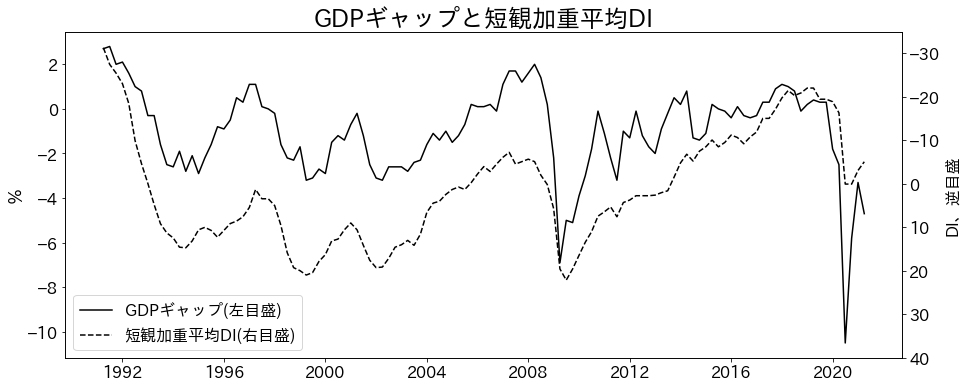

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot()
ax1.set_title("GDPギャップと短観加重平均DI", fontsize=24)
ax1.plot(dti, caogap, label="GDPギャップ(左目盛)", color="black")
ax1.grid(False)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("％", fontsize=16)
h1, l1 = ax1.get_legend_handles_labels()
ax2 = ax1.twinx()
ax2.plot(dti, tankan, label="短観加重平均DI(右目盛)", color="black", linestyle="dashed")
ax2.grid(False)
ax2.tick_params(labelsize=16)
ax2.invert_yaxis()
ax2.set_ylim(40, -35)
ax2.set_ylabel("DI、逆目盛", fontsize=16)
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="lower left", fontsize=16)

以下のコードでは、最初にAR(p)モデルによる予測を行い、次に短観加重平均DIによる予測を行ったうえで、DM検定を行う。なお、DM検定統計量の損失関数にはMSFEやMAFEなどを選択できるため、そのどちらを採用するかを選択できるようにしている。MSFEを損失関数としてDM検定統計量と修正DM検定統計量を計算した結果、図3.4を作成できる。

In [ ]:
# プログラム3.5
# DM検定
# 予測モデル1: AR(p)モデルによる予測
predict_result1_list, sqe_result1_list, aic_result1_list = [], [], []
PERIOD = 40  # 訓練データのサンプルサイズ（40四半期）
H = 1  # 予測期間（1四半期）
MAX_L = 4  # 最大ラグ次数（4四半期）
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(caogap)
nsample = len(data_x)

for l in range(1, MAX_L + 1):
    predict_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    sqe_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    aic_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    for i in range((nsample - H) - PERIOD - (MAX_L - 1)):
        train_x, test_x = pd.DataFrame(), pd.DataFrame()
        for ll in range(1, l + 1):
            # 訓練データの指定
            train_x_lagged = pd.DataFrame(
                np.ravel(
                    (
                        data_x.shift(-MAX_L + l)[i + l - ll : i + l - ll + PERIOD]
                    ).to_numpy()
                )
            )
            train_x = pd.concat([train_x, train_x_lagged], axis=1)
            train_y = data_y[i + H + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1)]
            # テストデータの指定
            test_x_lagged = pd.DataFrame(
                np.ravel(
                    (
                        data_x.shift(-MAX_L + l)[
                            i + l - ll + PERIOD : i + l - ll + PERIOD + 1
                        ]
                    ).to_numpy()
                )
            )
            test_x = pd.concat([test_x, test_x_lagged], axis=1)
            test_y = data_y[
                i + H + PERIOD + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1) + 1
            ]
        model = LinearRegression()
        model.fit(train_x, train_y)
        y_hat = model.predict(train_x)
        sse = ((train_y - y_hat) ** 2).sum(axis=0)
        aic = math.log(sse / len(train_y)) + (l + 1) * 2 / len(train_y)
        forecast = model.predict(test_x)
        sqe = ((test_y - forecast) ** 2).sum(axis=0)
        aic_result[i], predict_result[i], sqe_result[i] = aic, forecast, sqe

    predict_result1_list.append(predict_result)
    sqe_result1_list.append(sqe_result)
    aic_result1_list.append(aic_result)

# AICにより、ラグ次数を選択
trim_aic1, trim_predict1, trim_sqe1 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i in range(MAX_L):
    trim_aic1[i] = aic_result1_list[i]
    trim_predict1[i] = predict_result1_list[i]
    trim_sqe1[i] = sqe_result1_list[i]

d_length = nsample - H - PERIOD - MAX_L + 1
best_aic_lag1, best_aic_predict1, best_aic_sqe1 = (
    np.zeros(d_length),
    np.zeros(d_length),
    np.zeros(d_length),
)
for i in range(d_length):
    best_aic_lag1[i] = trim_aic1.iloc[i, :].idxmin() + 1
    best_aic_predict1[i] = trim_predict1.iloc[i, trim_aic1.iloc[i, :].idxmin()]
    best_aic_sqe1[i] = trim_sqe1.iloc[i, trim_aic1.iloc[i, :].idxmin()]


# 予測モデル2:短観加重平均DIを用いた予測
predict_result2_list, sqe_result2_list, aic_result2_list = [], [], []
PERIOD = 40  # 訓練データのサンプルサイズ（40四半期）
H = 1  # 予測期間（1四半期）
MAX_L = 4  # 最大ラグ次数（4四半期）
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(tankan)
nsample = len(data_x)

for l in range(1, MAX_L + 1):
    predict_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    sqe_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    aic_result = np.zeros((nsample - H) - PERIOD - (MAX_L - 1))
    for i in range((nsample - H) - PERIOD - (MAX_L - 1)):
        train_x, test_x = pd.DataFrame(), pd.DataFrame()
        for ll in range(1, l + 1):
            # 訓練データの指定
            train_x_lagged = pd.DataFrame(
                np.ravel(
                    (
                        data_x.shift(-MAX_L + l)[i + l - ll : i + l - ll + PERIOD]
                    ).to_numpy()
                )
            )
            train_x = pd.concat([train_x, train_x_lagged], axis=1)
            train_y = data_y[i + H + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1)]
            # テストデータの指定
            test_x_lagged = pd.DataFrame(
                np.ravel(
                    (
                        data_x.shift(-MAX_L + l)[
                            i + l - ll + PERIOD : i + l - ll + PERIOD + 1
                        ]
                    ).to_numpy()
                )
            )
            test_x = pd.concat([test_x, test_x_lagged], axis=1)
            test_y = data_y[
                i + H + PERIOD + (MAX_L - 1) : i + H + PERIOD + (MAX_L - 1) + 1
            ]
        model = LinearRegression()
        model.fit(train_x, train_y)
        y_hat = model.predict(train_x)
        sse = ((train_y - y_hat) ** 2).sum(axis=0)
        aic = math.log(sse / len(train_y)) + (l + 1) * 2 / len(train_y)
        forecast = model.predict(test_x)
        sqe = ((test_y - forecast) ** 2).sum(axis=0)
        aic_result[i], predict_result[i], sqe_result[i] = aic, forecast, sqe

    predict_result2_list.append(predict_result)
    sqe_result2_list.append(sqe_result)
    aic_result2_list.append(aic_result)

# AICにより、ラグ次数を選択
d_length = nsample - H - PERIOD - MAX_L + 1
trim_aic2, trim_predict2, trim_sqe2 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i in range(MAX_L):
    trim_aic2[i] = aic_result2_list[i]
    trim_predict2[i] = predict_result2_list[i]
    trim_sqe2[i] = sqe_result2_list[i]

best_aic_lag2, best_aic_predict2, best_aic_sqe2 = (
    np.zeros(d_length),
    np.zeros(d_length),
    np.zeros(d_length),
)
for i in range(d_length):
    best_aic_lag2[i] = trim_aic2.iloc[i, :].idxmin() + 1
    best_aic_predict2[i] = trim_predict2.iloc[i, trim_aic2.iloc[i, :].idxmin()]
    best_aic_sqe2[i] = trim_sqe2.iloc[i, trim_aic2.iloc[i, :].idxmin()]


# DM検定を行う際の基準(MSFEまたはMAFEを選択)
crit = str(input("損失関数を選択してください(MSFE、MAFEのいずれか): "))
actual_lst = np.ravel(data_y[H + PERIOD + MAX_L - 1 :])
pred1_lst, pred2_lst = best_aic_predict1, best_aic_predict2
e1_lst, e2_lst, d_lst = [], [], []
actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
tlen = float(len(actual_lst))
if crit == "MSFE":
    for actual, p1, p2 in zip(actual_lst, pred1_lst, pred2_lst):
        e1_lst.append((actual - p1) ** 2)
        e2_lst.append((actual - p2) ** 2)
    for e1, e2 in zip(e1_lst, e2_lst):
        d_lst.append(e1 - e2)
elif crit == "MAFE":
    for actual, p1, p2 in zip(actual_lst, pred1_lst, pred2_lst):
        e1_lst.append(abs(actual - p1))
        e2_lst.append(abs(actual - p2))
    for e1, e2 in zip(e1_lst, e2_lst):
        d_lst.append(e1 - e2)
mean_d = pd.Series(d_lst).mean()


def autocovariance(xi, n, k, xs):
    autocov = 0
    tlen = float(n)
    for i in np.arange(0, n - k):
        autocov += ((xi[i + k]) - xs) * (xi[i] - xs)
    return (1 / tlen) * autocov


gamma = []
for lag in range(0, H):
    gamma.append(autocovariance(d_lst, len(d_lst), lag, mean_d))
v_d = (gamma[0] + 2 * sum(gamma[1:])) / tlen
dm_stat = v_d ** (-0.5) * mean_d
pvalue_dm = 2 * norm.cdf(-abs(dm_stat), loc=0, scale=1)
mdm_stat = ((tlen + 1 - 2 * H + H * (H - 1) / tlen) / tlen) ** (0.5) * dm_stat
pvalue_mdm = 2 * t.cdf(-abs(mdm_stat), df=tlen - 1)

# DM検定統計量とp値を出力
dm_return = collections.namedtuple("dm_return", "DM p_value")
rt = dm_return(DM=dm_stat, p_value=pvalue_dm)
mrt = dm_return(DM=mdm_stat, p_value=pvalue_mdm)
print(f"DM検定:{rt}")
print(f"修正DM検定:{mrt}")

損失関数を選択してください(MSFE、MAFEのいずれか): MSFE
DM検定:dm_return(DM=0.6764679574414421, p_value=0.49874358337525937)
修正DM検定:dm_return(DM=0.6720609531515023, p_value=0.5035828900065175)


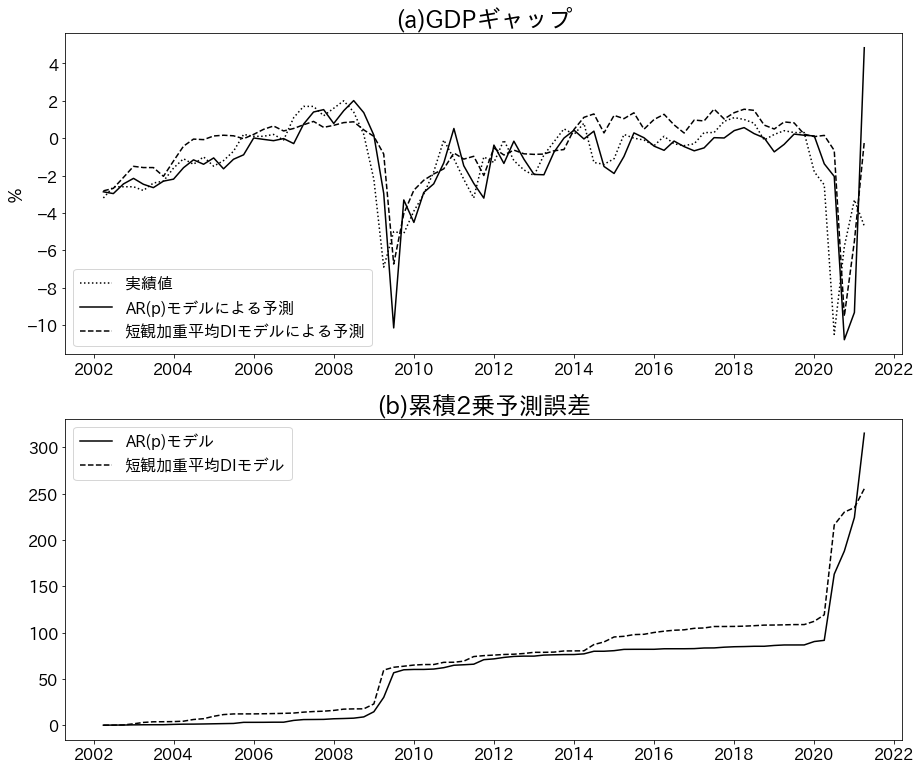

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)GDPギャップ", fontsize=24)
ax1.plot(dti[H + PERIOD + MAX_L - 1 :], actual_lst, label="実績値", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD + MAX_L - 1 :], pred1_lst, label="AR(p)モデルによる予測", color="black")
ax1.plot(dti[H + PERIOD + MAX_L - 1 :], pred2_lst, label="短観加重平均DIモデルによる予測", color="black", linestyle="dashed")
ax1.legend(loc="lower left", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)累積2乗予測誤差", fontsize=24)
ax2.plot(dti[H + PERIOD + MAX_L - 1 :], best_aic_sqe1.cumsum(), label="AR(p)モデル", color="black")
ax2.plot(dti[H + PERIOD + MAX_L - 1 :], best_aic_sqe2.cumsum(), label="短観加重平均DIモデル", color="black", linestyle="dashed")
ax2.legend(loc="upper left", fontsize=16)
ax2.tick_params(labelsize=16)

次は、VARモデルによる予測を紹介する。ここでは、内閣府のGDPギャップと総務省の消費者物価指数から計算されるインフレ率の2変数を用いてVARモデルによる予測を行う。まず、これらのデータを読み込むと、図3.5を作成できる。

In [ ]:
# プログラム3.6
# データの読み込み
cpi = pd.read_excel("/content/drive/My Drive/data_3.xlsx", sheet_name="消費者物価指数(総務省)", header=[0])
infl = cpi.iloc[:, 1]
dti = pd.date_range("1991-03-31", periods=len(gap), freq="QS")

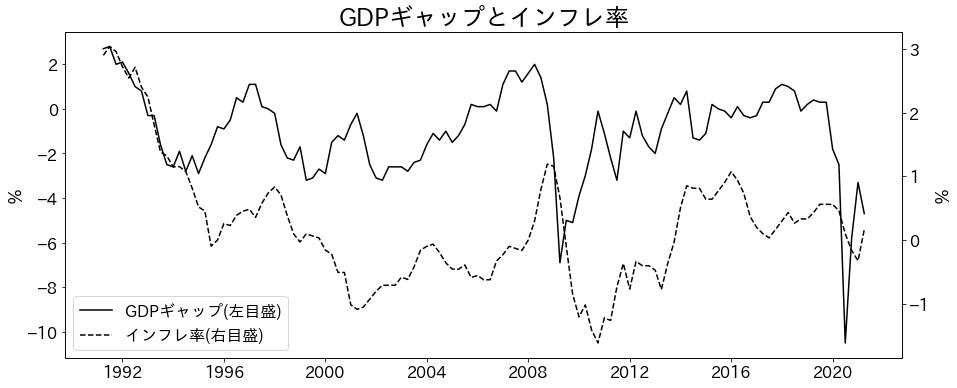

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot()
ax1.set_title("GDPギャップとインフレ率", fontsize=24)
ax1.plot(dti, caogap, label="GDPギャップ(左目盛)", color="black")
ax1.grid(False)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("％", fontsize=16)
h1, l1 = ax1.get_legend_handles_labels()
ax2 = ax1.twinx()
ax2.plot(dti, infl, label="インフレ率(右目盛)", color="black", linestyle="dashed")
ax2.grid(False)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("％", fontsize=16)
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="lower left", fontsize=16)

1991年第1四半期から2018年第4四半期までのGDPギャップとインフレ率のデータを用いてVAR(p)モデルを推定し、その1期先である2019年第1四半期から9期先である2021年第1四半期までの予測を行う。なお、コードの"maxlags"においてVAR(p)モデルの最大ラグ次数を12としているほか、"ic"においてラグ次数の選択にはAICを用いるように設定している。この結果、図3.6を作成することができる。

In [ ]:
# プログラム3.7
# VAR予測
data = np.zeros([len(gap), 2])
data[:, 0], data[:, 1] = caogap, infl
MAX_H = 9  # 最大予測期間（9四半期）
CONFIDENCE_LEVEL = 0.95  # 区間予測の信頼係数

# VARモデルを推定
model = VAR(data[:-MAX_H])
result = model.fit(maxlags=12, ic="aic")
lag_order = result.k_ar
print(f"ラグ次数: {lag_order}")

predict = result.forecast(data[-(lag_order + MAX_H) : -MAX_H], MAX_H)
var_forecast = (
    pd.concat([pd.DataFrame(data[0:-MAX_H]), pd.DataFrame(predict)], axis=0)
).to_numpy()
lbound, ubound = sp.stats.norm.interval(alpha=CONFIDENCE_LEVEL, loc=0, scale=1)
conf_result = np.zeros([MAX_H + 1, 2])
for h in range(1, MAX_H + 1, 1):
    list_fitted1 = []
    list_fitted2 = []
    for i in range(0, len(data) - (lag_order + h - 1) * 2, 1):
        fitted = result.forecast(data[i : i + lag_order], h)
        list_fitted1.append(fitted[h - 1, 0])
        list_fitted2.append(fitted[h - 1, 1])
        se1 = np.std(data[lag_order + h - 1 : i + lag_order + h, 0] - list_fitted1)
        se2 = np.std(data[lag_order + h - 1 : i + lag_order + h, 1] - list_fitted2)
    conf_result[h, 0], conf_result[h, 1] = se1 * ubound, se2 * ubound

ラグ次数: 2


Text(0, 0.5, '％')

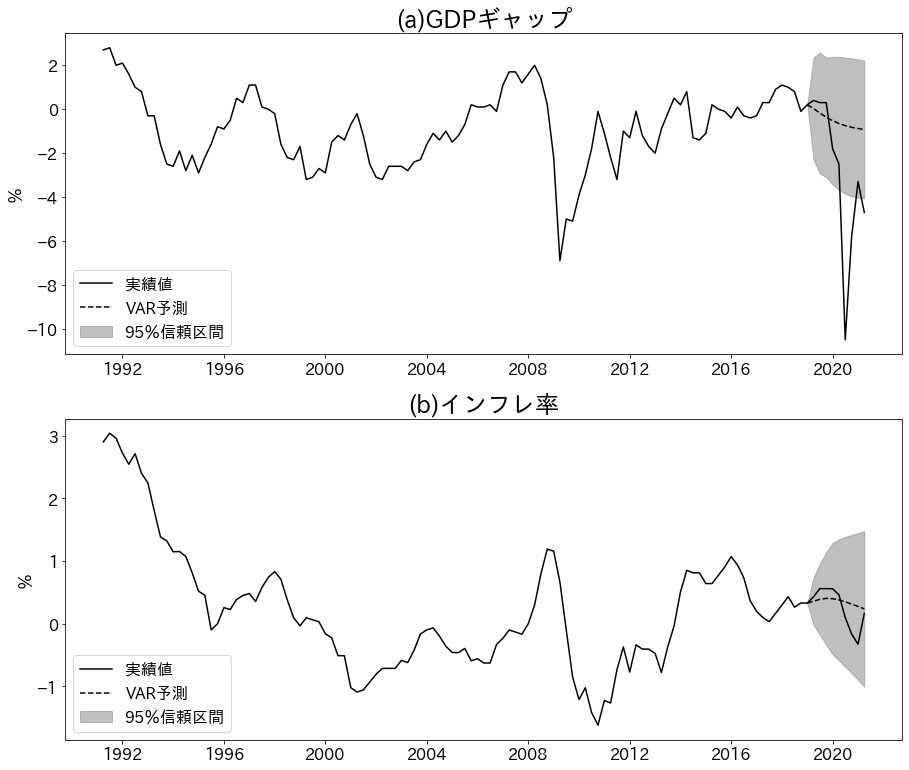

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)GDPギャップ", fontsize=24)
ax1.plot(dti, caogap, label="実績値", color="black")
ax1.plot(dti[-MAX_H - 1 :], var_forecast[-MAX_H - 1 :, 0], label="VAR予測", color="black", linestyle="dashed")
ax1.fill_between(
    dti[-MAX_H - 1 :],
    var_forecast[-MAX_H - 1 :, 0] + conf_result[:, 0],
    var_forecast[-MAX_H - 1 :, 0] - conf_result[:, 0],
    color="grey",
    alpha=0.5,
    label="95％信頼区間",
)
ax1.legend(loc="lower left", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)インフレ率", fontsize=24)
ax2.plot(dti, infl, label="実績値", color="black")
ax2.plot(dti[-MAX_H - 1 :], var_forecast[-MAX_H - 1 :, 1], label="VAR予測", color="black", linestyle="dashed")
ax2.fill_between(
    dti[-MAX_H - 1 :],
    var_forecast[-MAX_H - 1 :, 1] + conf_result[:, 1],
    var_forecast[-MAX_H - 1 :, 1] - conf_result[:, 1],
    color="grey",
    alpha=0.5,
    label="95％信頼区間",
)
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("％", fontsize=16)

1999年第1四半期から2021年第1四半期までのデータを用いて、グレンジャー因果性検定を行う。以下のコードでは、F検定統計量を用いる場合、ワルド検定統計量を用いる場合のそれぞれを示している。

In [ ]:
# プログラム3.8
# 全期間でVARを推定
model = VAR(data)
result = model.fit(maxlags=12, ic="aic")
print(f"ラグ次数: {result.k_ar}")

# グレンジャーの因果性検定（F統計量で検定、有意水準5％）
# 帰無仮説「y2（インフレ率）からy1（GDPギャップ）へグレンジャー因果性がない」
test12_outcome = result.test_causality("y1", "y2", kind="f", signif=0.05)
print(test12_outcome.summary())
# 帰無仮説「y1（GDPギャップ）からy2（インフレ率）へグレンジャー因果性がない」
test21_outcome = result.test_causality("y2", "y1", kind="f", signif=0.05)
print(test21_outcome.summary())

# グレンジャーの因果性検定（ワルド統計量で検定、有意水準5％）
# 帰無仮説「y2（インフレ率）からy1（GDPギャップ）へグレンジャー因果性がない」
test12_outcome = result.test_causality("y1", "y2", kind="wald", signif=0.05)
print(test12_outcome.summary())
# 帰無仮説「y1（GDPギャップ）からy2（インフレ率）へグレンジャー因果性がない」
test21_outcome = result.test_causality("y2", "y1", kind="wald", signif=0.05)
print(test21_outcome.summary())

ラグ次数: 5
Granger causality F-test. H_0: y2 does not Granger-cause y1. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.5626          2.257   0.729 (5, 210)
----------------------------------------------
Granger causality F-test. H_0: y1 does not Granger-cause y2. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         6.054          2.257   0.000 (5, 210)
----------------------------------------------
Granger causality Wald-test. H_0: y2 does not Granger-cause y1. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.813          11.07   0.729  5
----------------------------------------
Granger causality Wald-test. H_0: y1 does not Granger-cause y2. Conclusion: reject H_0 at 5% significan

混合頻度データによる予測を行う。高頻度(月次)系列として鉱工業生産指数と第3次産業活動指数、低頻度(四半期)系列としてGDPを用いる。はじめに、これらのデータを読み込む。

In [ ]:
# プログラム3.9
# 混合頻度データによる予測
# データの読み込み
data = pd.read_excel("/content/drive/My Drive/data_3.xlsx", sheet_name="混合頻度データ", header=[0])
data_m, data_q = data.iloc[:, 1 : 2 + 1], data.iloc[:, 4 : 4 + 1]
data_q = data_q.dropna()
mdlen, qdlen = len(data_m), len(data_q)
mdti = pd.date_range("1994-01-01", periods=mdlen, freq="MS")
qdti = pd.date_range("1994-01-01", periods=qdlen, freq="QS")
data_m, data_q = np.log(data_m).diff(1), np.log(data_q).diff(1)

PERIOD = 60  # 訓練データのサンプルサイズ（60四半期=180か月）

# 比較のためにAR(1)モデルによる予測を行う
predict_result10_list = []
H = 1  # 予測期間（1四半期）
L = 1  # ラグ次数（1四半期）
data_y = pd.DataFrame(data_q.iloc[1:,0])
data_x = pd.DataFrame(data_q.iloc[1:,0])
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD - (L - 1))
sqe_result = np.zeros((nsample - H) - PERIOD - (L - 1))
for i in range(0, (nsample - H) - PERIOD - (L - 1), 1):
    # 訓練データの指定
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[i + H + (L - 1) : i + H + PERIOD + (L - 1)]
    # テストデータの指定
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD + (L - 1) : i + H + PERIOD + (L - 1) + 1]
    predict_result[i], sqe_result[i] = train_and_predict_ar_model(
        train_x, train_y, test_x, test_y
    )
predict_result10_list.append(predict_result)

ブリッジモデルは、以下のコードで計算できる。

In [ ]:
# プログラム3.10
# ブリッジモデル
predict_result1_list, predict_result2_list, predict_result3_list = [], [], []
predict_result = np.zeros(((qdlen - 1) - PERIOD) * 3)
for k in range(1, qdlen - PERIOD):
    df_hatdata = data_m.iloc[3 * k : 3 * (k + PERIOD + 1), :]
    nd_hatdata = df_hatdata.to_numpy()

    # M3型ブリッジモデルを作成
    mqdata_before3 = df_hatdata.rolling(window=3, center=False).sum() / 3
    mqdata3 = np.zeros([PERIOD + 1, 2])
    for i in range(PERIOD + 1):
        mqdata3[i, :] = mqdata_before3.iloc[3 * (i + 1) - 1, :]
    x3 = mqdata3[0:PERIOD, :]
    y = data_q.iloc[k : k + PERIOD]
    model = LinearRegression()
    model.fit(x3, y)
    predict_result[3 * (k - 1) + 2] = model.predict(mqdata3[PERIOD : PERIOD + 1, :])
    predict_result3_list.append(predict_result[(k - 1) * 3 + 2])

    # M2型ブリッジモデルを作成
    fitted21 = pd.DataFrame(np.zeros([1, 2]))
    for j in range(2):
        tempx21 = pd.DataFrame(df_hatdata.iloc[:-1, j].to_numpy())
        tempy21 = pd.DataFrame(df_hatdata.iloc[1:, j].to_numpy())
        model = LinearRegression()
        model.fit(tempx21, tempy21)
        fitted21.iloc[0, j] = model.intercept_ + model.coef_ * df_hatdata.iloc[-2, j]
    hatdata2 = pd.concat([pd.DataFrame(nd_hatdata[:-1, :]), fitted21], axis=0)
    mqdata_before2 = hatdata2.rolling(window=3, center=False).sum() / 3
    mqdata2 = np.zeros([PERIOD + 1, 2])
    for i in range(PERIOD + 1):
        mqdata2[i, :] = mqdata_before2.iloc[3 * (i + 1) - 1, :]
    x2 = mqdata2[0:PERIOD, :]
    y = data_q.iloc[k : k + PERIOD]
    model = LinearRegression()
    model.fit(x2, y)
    predict_result[3 * (k - 1) + 1] = model.predict(mqdata2[PERIOD : PERIOD + 1, :])
    predict_result2_list.append(predict_result[(k - 1) * 3 + 1])

    # M1型ブリッジモデルを作成
    fitted11 = pd.DataFrame(np.zeros([1, 2]))
    fitted12 = pd.DataFrame(np.zeros([1, 2]))
    for j in range(2):
        tempx11 = pd.DataFrame(df_hatdata.iloc[:-1, j].to_numpy())
        tempy11 = pd.DataFrame(df_hatdata.iloc[1:, j].to_numpy())
        model = LinearRegression()
        model.fit(tempx11, tempy11)
        fitted11.iloc[0, j] = model.intercept_ + model.coef_ * df_hatdata.iloc[-3, j]
        tempx12 = pd.DataFrame(df_hatdata.iloc[:-2, j].to_numpy())
        tempy12 = pd.DataFrame(df_hatdata.iloc[2:, j].to_numpy())
        model = LinearRegression()
        model.fit(tempx12, tempy12)
        fitted12.iloc[0, j] = model.intercept_ + model.coef_ * df_hatdata.iloc[-3, j]
    hatdata1 = pd.concat([pd.DataFrame(nd_hatdata[:-2, :]), fitted11, fitted12], axis=0)
    mqdata_before1 = hatdata1.rolling(window=3, center=False).sum() / 3
    mqdata1 = np.zeros([PERIOD + 1, 2])
    for i in range(PERIOD + 1):
        mqdata1[i, :] = mqdata_before1.iloc[3 * (i + 1) - 1, :]
    x1 = mqdata1[0:PERIOD, :]
    y = data_q.iloc[k : k + PERIOD]
    model = LinearRegression()
    model.fit(x1, y)
    predict_result[3 * (k - 1)] = model.predict(mqdata1[PERIOD : PERIOD + 1, :])
    predict_result1_list.append(predict_result[(k - 1) * 3])

MIDASモデルは、以下のコードで計算できる。

In [ ]:
# プログラム3.11
# MIDASモデル
predict_result4_list, predict_result5_list, predict_result6_list = [], [], []
predict_result = np.zeros(((qdlen - 1) - PERIOD) * 3)
for k in range(1, qdlen - PERIOD):
    # 非線形最小2乗法によりパラメータを推定
    def fit_func(parameter, xx, y):
        x11, x12, x13, x21, x22, x23 = xx
        a, b, c, d, e = parameter
        residual = (
            y
            - a
            - b
            * (
                (np.exp(0) / np.exp(c * 3 + d * 5)) * x13
                + (np.exp(c * 1 + d * 1) / np.exp(c * 3 + d * 5)) * x12
                + (np.exp(c * 2 + d * 4) / np.exp(c * 3 + d * 5)) * x11
            )
            - e
            * (
                (np.exp(0) / np.exp(c * 3 + d * 5)) * x23
                + (np.exp(c * 1 + d * 1) / np.exp(c * 3 + d * 5)) * x22
                + (np.exp(c * 2 + d * 4) / np.exp(c * 3 + d * 5)) * x21
            )
        )
        return residual

    
    parameter0 = [0, 0, 0, 0, 0]

    # M3型MIDASモデルを作成
    y = np.ravel(data_q[k : k + PERIOD].to_numpy())
    x11 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 0].to_numpy()
    x12 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 0].to_numpy()
    x13 = data_m[3 * k + 2 : 3 * (k + PERIOD) + 2 : 3].iloc[:, 0].to_numpy()
    x21 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 1].to_numpy()
    x22 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 1].to_numpy()
    x23 = data_m[3 * k + 2 : 3 * (k + PERIOD) + 2 : 3].iloc[:, 1].to_numpy()
    result = sp.optimize.leastsq(
        fit_func, parameter0, args=((x11, x12, x13, x21, x22, x23), y)
    )
    a_fit, b_fit, c_fit, d_fit, e_fit = (
        result[0][0],
        result[0][1],
        result[0][2],
        result[0][3],
        result[0][4],
    )
    predict_result[3 * (k - 1) + 2] = (
        a_fit
        + b_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) + 2, 0]
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) + 1, 0]
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD), 0]
        )
        + e_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) + 2, 1]
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) + 1, 1]
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD), 1]
        )
    )
    predict_result6_list.append(predict_result[3 * (k - 1) + 2])

    # M2型MIDASモデルを作成
    y = np.ravel(data_q[k : k + PERIOD].to_numpy())
    x11 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 0].to_numpy()
    x12 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 0].to_numpy()
    x13 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 0].to_numpy()
    x21 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 1].to_numpy()
    x22 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 1].to_numpy()
    x23 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 1].to_numpy()
    result = sp.optimize.leastsq(
        fit_func, parameter0, args=((x13, x11, x12, x23, x21, x22), y)
    )
    a_fit, b_fit, c_fit, d_fit, e_fit = (
        result[0][0],
        result[0][1],
        result[0][2],
        result[0][3],
        result[0][4],
    )
    predict_result[3 * (k - 1) + 1] = (
        a_fit
        + b_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) + 1, 0]
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD), 0]
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) - 1, 0]
        )
        + e_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) + 1, 1]
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD), 1]
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) - 1, 1]
        )
    )
    predict_result5_list.append(predict_result[3 * (k - 1) + 1])

    # M1型MIDASモデルを作成
    y = np.ravel(data_q[k : k + PERIOD].to_numpy())
    x11 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 0].to_numpy()
    x12 = data_m[3 * k - 2 : 3 * (k + PERIOD) - 2 : 3].iloc[:, 0].to_numpy()
    x13 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 0].to_numpy()
    x21 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 1].to_numpy()
    x22 = data_m[3 * k - 2 : 3 * (k + PERIOD) - 2 : 3].iloc[:, 1].to_numpy()
    x23 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 1].to_numpy()
    result = sp.optimize.leastsq(
        fit_func, parameter0, args=((x12, x13, x11, x22, x23, x21), y)
    )
    a_fit, b_fit, c_fit, d_fit, e_fit = (
        result[0][0],
        result[0][1],
        result[0][2],
        result[0][3],
        result[0][4],
    )
    predict_result[3 * (k - 1)] = (
        a_fit
        + b_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD), 0]
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) - 1, 0]
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) - 2, 0]
        )
        + e_fit
        * (
            (np.exp(0) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD), 1]
            + (np.exp(c_fit * 1 + d_fit * 1) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) - 1, 1]
            + (np.exp(c_fit * 2 + d_fit * 4) / np.exp(c_fit * 3 + d_fit * 5))
            * data_m.iloc[3 * (k + PERIOD) - 2, 1]
        )
    )
    predict_result4_list.append(predict_result[3 * (k - 1)])

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


U-MIDASモデルは、以下のコードで計算できる。

In [ ]:
# プログラム3.12
# U-MIDASモデル
predict_result7_list, predict_result8_list, predict_result9_list = [], [], []
predict_result = np.zeros(((qdlen - 1) - PERIOD) * 3)
for k in range(1, qdlen - PERIOD):

    # M3型U-MIDASモデルを作成
    y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x11 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 0].to_numpy()
    x12 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 0].to_numpy()
    x13 = data_m[3 * k + 2 : 3 * (k + PERIOD) + 2 : 3].iloc[:, 0].to_numpy()
    x21 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 1].to_numpy()
    x22 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 1].to_numpy()
    x23 = data_m[3 * k + 2 : 3 * (k + PERIOD) + 2 : 3].iloc[:, 1].to_numpy()
    x = pd.concat(
        [
            pd.DataFrame(x11),
            pd.DataFrame(x12),
            pd.DataFrame(x13),
            pd.DataFrame(x21),
            pd.DataFrame(x22),
            pd.DataFrame(x23),
        ],
        axis=1,
    )
    model = LinearRegression()
    model.fit(x, y)
    x11_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD), 0]])
    x12_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) + 1, 0]])
    x13_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) + 2, 0]])
    x21_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD), 1]])
    x22_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) + 1, 1]])
    x23_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) + 2, 1]])
    x_p = pd.concat([x11_p, x12_p, x13_p, x21_p, x22_p, x23_p], axis=1)
    predict_result[3 * (k - 1) + 2] = model.predict(x_p)
    predict_result9_list.append(predict_result[3 * (k - 1) + 2])

    # M2型U-MIDASモデルを作成
    y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x11 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 0].to_numpy()
    x12 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 0].to_numpy()
    x13 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 0].to_numpy()
    x21 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 1].to_numpy()
    x22 = data_m[3 * k + 1 : 3 * (k + PERIOD) + 1 : 3].iloc[:, 1].to_numpy()
    x23 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 1].to_numpy()
    x = pd.concat(
        [
            pd.DataFrame(x13),
            pd.DataFrame(x11),
            pd.DataFrame(x12),
            pd.DataFrame(x23),
            pd.DataFrame(x21),
            pd.DataFrame(x22),
        ],
        axis=1,
    )
    model = LinearRegression()
    model.fit(x, y)
    x11_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD), 0]])
    x12_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) + 1, 0]])
    x13_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) - 1, 0]])
    x21_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD), 1]])
    x22_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) + 1, 1]])
    x23_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) - 1, 1]])
    x_p = pd.concat([x13_p, x11_p, x12_p, x23_p, x21_p, x22_p], axis=1)
    predict_result[3 * (k - 1) + 1] = model.predict(x_p)
    predict_result8_list.append(predict_result[3 * (k - 1) + 1])

    # M1型U-MIDASモデルを作成
    y = pd.DataFrame(data_q[k : k + PERIOD].to_numpy())
    x11 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 0].to_numpy()
    x12 = data_m[3 * k - 2 : 3 * (k + PERIOD) - 2 : 3].iloc[:, 0].to_numpy()
    x13 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 0].to_numpy()
    x21 = data_m[3 * k : 3 * (k + PERIOD) : 3].iloc[:, 1].to_numpy()
    x22 = data_m[3 * k - 2 : 3 * (k + PERIOD) - 2 : 3].iloc[:, 1].to_numpy()
    x23 = data_m[3 * k - 1 : 3 * (k + PERIOD) - 1 : 3].iloc[:, 1].to_numpy()
    x = pd.concat(
        [
            pd.DataFrame(x12),
            pd.DataFrame(x13),
            pd.DataFrame(x11),
            pd.DataFrame(x22),
            pd.DataFrame(x23),
            pd.DataFrame(x21),
        ],
        axis=1,
    )
    model = LinearRegression()
    model.fit(x, y)
    x11_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD), 0]])
    x12_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) - 2, 0]])
    x13_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) - 1, 0]])
    x21_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD), 1]])
    x22_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) - 2, 1]])
    x23_p = pd.DataFrame([data_m.iloc[3 * (k + PERIOD) - 1, 1]])
    x_p = pd.concat([x12_p, x13_p, x11_p, x22_p, x23_p, x21_p], axis=1)
    predict_result[3 * (k - 1)] = model.predict(x_p)
    predict_result7_list.append(predict_result[3 * (k - 1)])

ここまでの結果をまとめると、図3.7を作成できる。

Text(0, 0.5, '％')

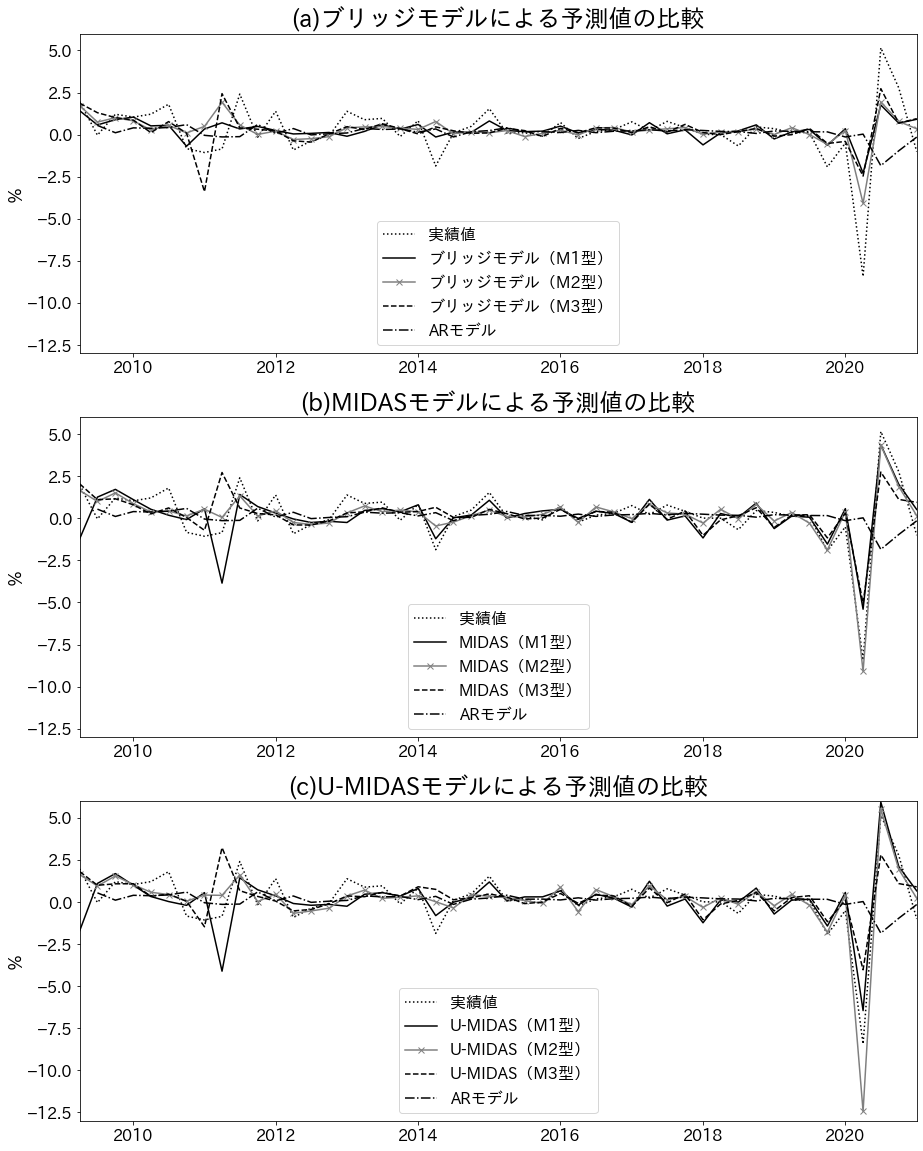

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.set_title("(a)ブリッジモデルによる予測値の比較", fontsize=24)
ax1.plot(qdti[PERIOD + 1 :], data_q.iloc[PERIOD + 1 :, 0] * 100, label="実績値", color="black", linestyle="dotted")
ax1.plot(qdti[PERIOD + 1 :], np.ravel(predict_result1_list) * 100, label="ブリッジモデル（M1型）", color="black")
ax1.plot(qdti[PERIOD + 1 :], np.ravel(predict_result2_list) * 100, label="ブリッジモデル（M2型）", color="grey", marker="x")
ax1.plot(qdti[PERIOD + 1 :], np.ravel(predict_result3_list) * 100, label="ブリッジモデル（M3型）", color="black", linestyle="dashed")
ax1.plot(qdti[PERIOD + 2 :], np.ravel(predict_result10_list) * 100, label="ARモデル", color="black", linestyle="dashdot")
ax1.legend(loc="lower center", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_xlim(qdti[PERIOD + 1], qdti[-1])
ax1.set_ylim(-13, 6)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)MIDASモデルによる予測値の比較", fontsize=24)
ax2.plot(qdti[PERIOD + 1 :], data_q.iloc[PERIOD + 1 :, 0] * 100, label="実績値", color="black", linestyle="dotted")
ax2.plot(qdti[PERIOD + 1 :], np.ravel(predict_result4_list) * 100, label="MIDAS（M1型）", color="black")
ax2.plot(qdti[PERIOD + 1 :], np.ravel(predict_result5_list) * 100, label="MIDAS（M2型）", color="grey", marker="x")
ax2.plot(qdti[PERIOD + 1 :], np.ravel(predict_result6_list) * 100, label="MIDAS（M3型）", color="black", linestyle="dashed")
ax2.plot(qdti[PERIOD + 2 :], np.ravel(predict_result10_list) * 100, label="ARモデル", color="black", linestyle="dashdot")
ax2.legend(loc="lower center", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_xlim(qdti[PERIOD + 1], qdti[-1])
ax2.set_ylim(-13, 6)
ax2.set_ylabel("％", fontsize=16)
ax3.set_title("(c)U-MIDASモデルによる予測値の比較", fontsize=24)
ax3.plot(qdti[PERIOD + 1 :], data_q.iloc[PERIOD + 1 :, 0] * 100, label="実績値", color="black", linestyle="dotted")
ax3.plot(qdti[PERIOD + 1 :], np.ravel(predict_result7_list) * 100, label="U-MIDAS（M1型）", color="black")
ax3.plot(qdti[PERIOD + 1 :], np.ravel(predict_result8_list) * 100, label="U-MIDAS（M2型）", color="grey", marker="x")
ax3.plot(qdti[PERIOD + 1 :], np.ravel(predict_result9_list) * 100, label="U-MIDAS（M3型）", color="black", linestyle="dashed")
ax3.plot(qdti[PERIOD + 2 :], np.ravel(predict_result10_list) * 100, label="ARモデル", color="black", linestyle="dashdot")
ax3.legend(loc="lower center", fontsize=16)
ax3.tick_params(labelsize=16)
ax3.set_xlim(qdti[PERIOD + 1], qdti[-1])
ax3.set_ylim(-13, 6)
ax3.set_ylabel("％", fontsize=16)

合成予測は、以下のコードで計算できる。最初に、GDPギャップを目的変数とし、6つのモデル(AR(1)モデル、短観加重平均DIを予測変数とするモデル、失業率を予測変数とするモデル、有効求人倍率を予測変数とするモデル、鉱工業生産指数を予測変数とするモデル、第3次産業活動指数を予測変数とするモデル)からそれぞれの予測を作成する。続いて、これら6つの予測に対して、算術平均の合成予測、(3.25)式の合成予測、OLSの合成予測を計算すると、図3.8を作成できる。

In [ ]:
# プログラム3.10
# ６つの予測方法により、GDPギャップを予測
# データの読み込み
labor = pd.read_excel("/content/drive/My Drive/data_3.xlsx", sheet_name="失業率(総務省)と有効求人倍率(厚生労働省)", header=[0])
activity = pd.read_excel(
    "/content/drive/My Drive/data_3.xlsx", sheet_name="鉱工業生産指数と第3次産業活動指数(経済産業省)", header=[0]
)
ur, ota = labor.iloc[:, 1], labor.iloc[:, 2]
iip, sai = activity.iloc[:, 1], activity.iloc[:, 2]
dti = pd.date_range("1991-03-31", periods=len(gap), freq="Q")
PERIOD = 40  # 訓練データのサンプルサイズ（40四半期）
H = 1  # 予測期間（1四半期）

# 予測1:AR(1)による予測
predict_result1_list = []
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(caogap)
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD)
for i in range((nsample - H) - PERIOD):
    # 訓練データの指定
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # テストデータの指定
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD : i + H + PERIOD + 1]
    # モデル推定
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
predict_result1_list.append(predict_result)

# 予測2:短観DI（tankan）による予測
predict_result2_list = []
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(tankan)
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD)
for i in range((nsample - H) - PERIOD):
    # 訓練データの指定
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # テストデータの指定
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD : i + H + PERIOD + 1]
    # モデル推定
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
predict_result2_list.append(predict_result)

# 予測3:失業率（ur）による予測
predict_result3_list = []
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(ur)
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD)
for i in range((nsample - H) - PERIOD):
    # 訓練データの指定
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # テストデータの指定
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD : i + H + PERIOD + 1]
    # モデル推定
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
predict_result3_list.append(predict_result)

# 予測4:有効求人倍率（ota）による予測
predict_result4_list = []
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(ota)
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD)
for i in range((nsample - H) - PERIOD):
    # 訓練データの指定
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # テストデータの指定
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD : i + H + PERIOD + 1]
    # モデル推定
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
predict_result4_list.append(predict_result)

# 予測5:鉱工業生産指数（iip）による予測
predict_result5_list = []
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(iip)
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD)
for i in range((nsample - H) - PERIOD):
    # 訓練データの指定
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # テストデータの指定
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD : i + H + PERIOD + 1]
    # モデル推定
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
predict_result5_list.append(predict_result)

# 予測6:第３次産業活動指数（sai）による予測
predict_result6_list = []
data_y = pd.DataFrame(caogap)
data_x = pd.DataFrame(sai)
nsample = len(data_x)
predict_result = np.zeros((nsample - H) - PERIOD)
for i in range((nsample - H) - PERIOD):
    # 訓練データの指定
    train_x = data_x[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # テストデータの指定
    test_x = data_x[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[i + H + PERIOD : i + H + PERIOD + 1]
    # モデル推定
    model = LinearRegression()
    model.fit(train_x, train_y)
    forecast = model.predict(test_x)
    predict_result[i] = forecast
predict_result6_list.append(predict_result)

# 実績値と予測値を集約
pack = pd.concat(
    [
        pd.DataFrame(caogap[h + PERIOD :].to_numpy()),
        pd.DataFrame(predict_result1_list).T,
        pd.DataFrame(predict_result2_list).T,
        pd.DataFrame(predict_result3_list).T,
        pd.DataFrame(predict_result4_list).T,
        pd.DataFrame(predict_result5_list).T,
        pd.DataFrame(predict_result6_list).T,
    ],
    axis=1,
)


# 算術平均による合成予測
def compute_am(pack):
    am_weight = np.zeros([len(pack.T) - 1, 1])
    for i in range(0, len(am_weight), 1):
        am_weight[i] = 1 / (len(pack.T) - 1)
    fitted_am = np.mean(pack.iloc[:, 1 : len(pack.T)], axis=1)
    return fitted_am, am_weight


# Bates and Granger (1969)の最適合成予測
def compute_bg(pack):
    fitted_bg = np.zeros([len(pack), 1])
    sigma = np.zeros([len(pack.T) - 1, 1])
    bg_weight = np.zeros([len(pack.T) - 1, 1])
    for i in range(1, len(pack.T), 1):
        x = pd.DataFrame(pack.iloc[:, i])
        y = pd.DataFrame(pack.iloc[:, 0])
        model = LinearRegression()
        model.fit(x, y)
        fv = model.predict(x)
        resid = (y - fv) ** 2
        sigma[i - 1] = (np.sum(resid)) ** (-2)
    bg_weight = sigma / np.sum(sigma)
    for i in range(0, len(pack), 1):
        fitted_bg[i] = np.dot(pack.iloc[i, 1:], bg_weight)
    return fitted_bg, bg_weight


# OLSによる最適合成予測
def compute_gr(pack):
    fitted_gr = np.zeros([len(pack), 1])
    dep = pack.iloc[:, 0].to_numpy()
    exp = pack.iloc[:, 1:].to_numpy()
    ax = np.ones([len(pack.T) - 1, 1]).T
    bx = 1
    param_gr = cvxpy.Variable(len(pack.T) - 1)
    objective = cvxpy.sum_squares(dep - exp @ param_gr)
    constraints = [ax @ param_gr == bx, param_gr >= 0]
    prob = cvxpy.Problem(cvxpy.Minimize(objective), constraints)
    prob.solve()
    for i in range(0, len(pack), 1):
        fitted_gr[i] = np.dot(pack.iloc[i, 1:], param_gr.value)
    gr_weight = param_gr.value.reshape([len(pack.T) - 1, 1])
    return fitted_gr, gr_weight


weight_am_list, weight_bg_list, weight_gr_list = [], [], []
am_list, bg_list, gr_list = [], [], []
nsample = len(pd.DataFrame(caogap))
predict_result = np.zeros((nsample - H) - PERIOD)
data_y = pd.DataFrame(caogap)
data_x1 = pd.DataFrame(caogap)
data_x2 = pd.DataFrame(tankan)
data_x3 = pd.DataFrame(ur)
data_x4 = pd.DataFrame(ota)
data_x5 = pd.DataFrame(iip)
data_x6 = pd.DataFrame(sai)
for i in range((nsample - H) - PERIOD):
    pack_train = pd.DataFrame(train_y.to_numpy()).copy()
    pack_test = pd.DataFrame(test_y.to_numpy()).copy()
    pack_test_demean = pd.DataFrame(
        test_y.to_numpy() - np.mean(train_y.to_numpy())
    ).copy()
    # 訓練データの指定
    train_x1 = data_x1[i : i + PERIOD]
    train_x2 = data_x2[i : i + PERIOD]
    train_x3 = data_x3[i : i + PERIOD]
    train_x4 = data_x4[i : i + PERIOD]
    train_x5 = data_x5[i : i + PERIOD]
    train_x6 = data_x6[i : i + PERIOD]
    train_y = data_y[H + i : H + i + PERIOD]
    # テストデータの指定
    test_x1 = data_x1[i + PERIOD : i + PERIOD + 1]
    test_x2 = data_x2[i + PERIOD : i + PERIOD + 1]
    test_x3 = data_x3[i + PERIOD : i + PERIOD + 1]
    test_x4 = data_x4[i + PERIOD : i + PERIOD + 1]
    test_x5 = data_x5[i + PERIOD : i + PERIOD + 1]
    test_x6 = data_x6[i + PERIOD : i + PERIOD + 1]
    test_y = data_y[H + i + PERIOD : H + i + PERIOD + 1]
    # モデル推定
    model1 = LinearRegression()
    model2 = LinearRegression()
    model3 = LinearRegression()
    model4 = LinearRegression()
    model5 = LinearRegression()
    model6 = LinearRegression()
    model1.fit(train_x1, train_y)
    model2.fit(train_x2, train_y)
    model3.fit(train_x3, train_y)
    model4.fit(train_x4, train_y)
    model5.fit(train_x5, train_y)
    model6.fit(train_x6, train_y)
    fitted1 = model1.predict(train_x1)
    fitted2 = model2.predict(train_x2)
    fitted3 = model3.predict(train_x3)
    fitted4 = model4.predict(train_x4)
    fitted5 = model5.predict(train_x5)
    fitted6 = model6.predict(train_x6)
    pack_train = pd.concat(
        [
            pd.DataFrame(train_y.to_numpy()),
            pd.DataFrame(fitted1),
            pd.DataFrame(fitted2),
            pd.DataFrame(fitted3),
            pd.DataFrame(fitted4),
            pd.DataFrame(fitted5),
            pd.DataFrame(fitted6),
        ],
        axis=1,
    )
    forecast1 = model1.predict(test_x1)
    forecast2 = model2.predict(test_x2)
    forecast3 = model3.predict(test_x3)
    forecast4 = model4.predict(test_x4)
    forecast5 = model5.predict(test_x5)
    forecast6 = model6.predict(test_x6)
    pack_test = pd.concat(
        [
            pd.DataFrame(test_y.to_numpy()),
            pd.DataFrame(forecast1),
            pd.DataFrame(forecast2),
            pd.DataFrame(forecast3),
            pd.DataFrame(forecast4),
            pd.DataFrame(forecast5),
            pd.DataFrame(forecast6),
        ],
        axis=1,
    )

    # 合成予測の重みを計算
    am_weight = compute_am(pack_train)[1]
    bg_weight = compute_bg(pack_train)[1]
    gr_weight = compute_gr(pack_train)[1]
    weight_am_list.append(am_weight.T)
    weight_bg_list.append(bg_weight.T)
    weight_gr_list.append(gr_weight.T)
    
    am = np.dot(pack_test.to_numpy()[0, 1:], am_weight)
    bg = np.dot(pack_test.to_numpy()[0, 1:], bg_weight)
    gr = np.dot(pack_test.to_numpy()[0, 1:], gr_weight)
    am_list.append(am)
    bg_list.append(bg)
    gr_list.append(gr)

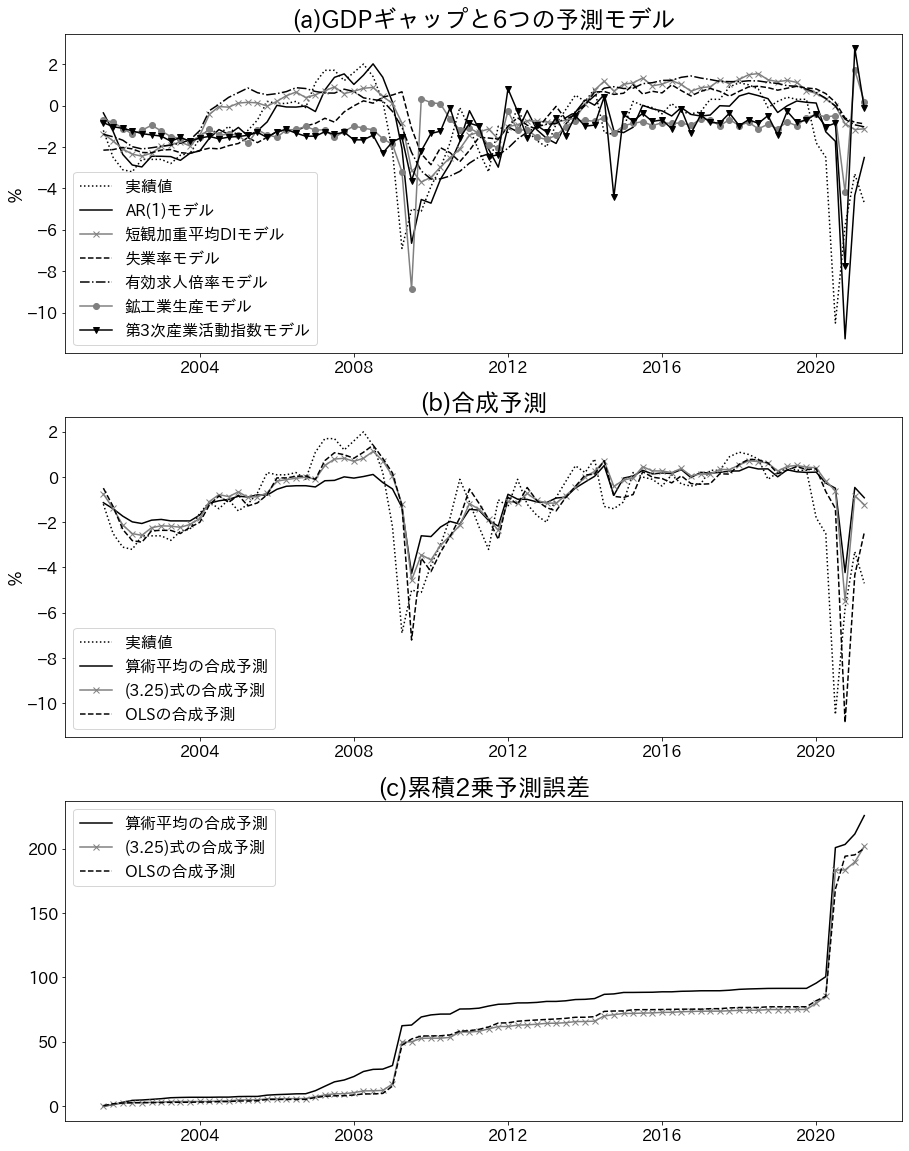

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.set_title("(a)GDPギャップと6つの予測モデル", fontsize=24)
ax1.plot(dti[H + PERIOD :], caogap[H + PERIOD :], label="実績値", color="black", linestyle="dotted")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result1_list), label="AR(1)モデル", color="black")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result2_list), label="短観加重平均DIモデル", color="grey", marker="x")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result3_list), label="失業率モデル", color="black", linestyle="dashed")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result4_list), label="有効求人倍率モデル", color="black", linestyle="dashdot")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result5_list), label="鉱工業生産モデル", color="grey", marker="o")
ax1.plot(dti[H + PERIOD :], np.ravel(predict_result6_list), label="第3次産業活動指数モデル", color="black",marker="v")
ax1.legend(loc="lower left", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("％", fontsize=16)
ax2.set_title("(b)合成予測", fontsize=24)
ax2.plot(dti[H + PERIOD :], caogap[H + PERIOD :], label="実績値", color="black", linestyle="dotted")
ax2.plot(dti[H + PERIOD :], np.ravel(am_list), label="算術平均の合成予測", color="black")
ax2.plot(dti[H + PERIOD :], np.ravel(bg_list), label="(3.25)式の合成予測", color="grey", marker="x")
ax2.plot(dti[H + PERIOD :], np.ravel(gr_list), label="OLSの合成予測", color="black", linestyle="dashed")
ax2.legend(loc="lower left", fontsize=16)
ax2.tick_params(labelsize=16)
ax2.set_ylabel("％", fontsize=16)
ax3.set_title("(c)累積2乗予測誤差", fontsize=24)
ax3.plot(dti[H + PERIOD :], ((caogap[H+PERIOD:]-np.ravel(am_list))**2).cumsum(), label="算術平均の合成予測", color='black')
ax3.plot(dti[H + PERIOD :], ((caogap[H+PERIOD:]-np.ravel(bg_list))**2).cumsum(), label="(3.25)式の合成予測", color="grey", marker="x")
ax3.plot(dti[H + PERIOD :], ((caogap[H+PERIOD:]-np.ravel(gr_list))**2).cumsum(),label="OLSの合成予測", color="black", linestyle="dashed")
ax3.legend(loc="upper left",fontsize=16)
ax3.tick_params(labelsize=16)

ベイジアン・モデル平均は、以下のコードで計算できる。ベイジアン・モデル平均では、MCMC法により合成予測の重みを計算する。ここでは、日本の月次マクロ経済変数219系列を対象に、その130系列目の実質賃金の1か月先の前年比を残りの218系列の変数選択の組み合わせ$2^{218}$通りからベイジアン・モデル平均により計算している。これにより、図3.9を作成できる。

In [ ]:
# プログラム3.11
# ベイジアン・モデル平均
# データの読み込み
ms = pd.read_excel("/content/drive/My Drive/data_3.xlsx", sheet_name="MS(JJIE2020)", header=[0])
data = pd.concat(
    [pd.DataFrame(ms.iloc[1:, 129].to_numpy()),
     pd.DataFrame(ms.iloc[:-1, :129].to_numpy()),
     pd.DataFrame(ms.iloc[:-1, 130:].to_numpy())],
    axis=1
)
dti = pd.date_range("1974-01-01", periods=len(data), freq="MS")

def compute_bma(pack):
    n = len(pack)
    y = pack.iloc[:, 0]
    xraw = pack.iloc[:, 1:]
    bigk = len(xraw.T)

    mxraw_num = np.mean(xraw)
    mxraw = pd.DataFrame(np.zeros([n, bigk]))
    for i in range(bigk):
        mxraw.iloc[:, i] = np.reshape(np.ones([n, 1]) * mxraw_num.iloc[i], (n))

    xdemean = pd.DataFrame(np.zeros([n, bigk]))
    for i in range(bigk):
        xdemean.iloc[:, i] = xraw.iloc[:, i] - mxraw.iloc[:, i]

    molddraw = np.zeros([bigk, 1])
    xold = np.append(np.ones([n, 1]), xdemean, axis=1)
    xtxinv = np.linalg.inv(np.matmul(xold.T, xold))
    bhat = np.matmul(np.matmul(xtxinv, xold.T), y)
    e = y - np.matmul(xold, bhat)
    sse = np.matmul(e.T, e)
    s2 = sse / (n - bigk - 1)
    bcov = s2 * xtxinv
    bt = pd.DataFrame(np.zeros([bigk + 1, 1]))
    for i in range(1, bigk + 1):
        bt[i] = bhat[i] / math.sqrt(bcov[i, i])
        if abs(bt.iloc[i, i]) > 0.5:
            molddraw[i - 1] = 1
    xold = np.ones([n, 1])
    kold = sum(molddraw) + 1
    for i in range(bigk):
        if molddraw[i] > 0:
            xold = np.append(
                xold, np.reshape((xdemean.iloc[:, i]).to_numpy(), (n, 1)), axis=1
            )
    # 事前分布の設定
    if n <= (bigk**2):
        g0 = 1 / (bigk**2)
    else:
        g0 = 1 / n
    yty = np.matmul((y - np.mean(y)).T, (y - np.mean(y)))
    xtxinv = np.linalg.inv(np.matmul(xold.T, xold))
    ymy = np.matmul(y.T, y) - np.matmul(
        np.matmul(np.matmul(np.matmul(y.T, xold), xtxinv), xold.T), y
    )
    g1 = g0 / (g0 + 1)
    g2 = 1 / (g0 + 1)
    lprobold = 0.5 * kold * np.log(g1) - 0.5 * (n - 1) * np.log(g2 * ymy + g1 * yty)
    inccount = np.zeros([bigk, 1])
    msize = 0
    # 上位10モデルの選択
    top10mod = molddraw
    jj = 1
    while jj < 10:
        top10mod = np.append(top10mod, molddraw, axis=1)
        jj = jj + 1
    lprobtop10 = lprobold * np.ones([10, 1])
    top10count = np.zeros([10, 1])
    b1mo, b2mo = np.zeros([bigk, 1]), np.zeros([bigk, 1])
    nburn, nkeep = 2000, 20000
    nrep = nburn + nkeep
    mnewdraw = np.zeros([len(molddraw), len(molddraw.T)])
    for irep in range(nrep):
        indch = round(bigk * np.random.rand())
        xnew = xold
        for i in range(len(molddraw)):
            mnewdraw[i] = molddraw[i]
        if indch > 0:
            if molddraw[indch - 1] == 1:
                isum = 0
                for i in range(0, indch):
                    isum = isum + molddraw[i]
                xnew = np.append(
                    xold[:, 0 : int(isum)], xold[:, int(isum) + 1 : int(kold)], axis=1
                )
                mnewdraw[indch - 1] = 0
            else:
                isum = 0
                for i in range(0, indch):
                    isum = isum + molddraw[i]
                xnew_before = np.append(
                    xold[:, 0 : int(isum) + 1],
                    np.reshape(xdemean.iloc[:, indch - 1].to_numpy(), (n, 1)),
                    axis=1,
                )
                xnew = np.append(
                    xnew_before, xold[:, int(isum) + 1 : int(kold)], axis=1
                )
                mnewdraw[indch - 1] = 1
        knew = sum(mnewdraw) + 1
        xtxinv = np.linalg.pinv(np.matmul(xnew.T, xnew))
        ymy = np.matmul(y.T, y) - np.matmul(
            np.matmul(np.matmul(np.matmul(y.T, xnew), xtxinv), xnew.T), y
        )
        lprobnew = 0.5 * knew * np.log(g1) - 0.5 * (n - 1) * np.log(g2 * ymy + g1 * yty)
        if np.log(np.random.rand()) < (lprobnew - lprobold):
            xold = xnew
            for i in range(0, len(mnewdraw)):
                molddraw[i] = mnewdraw[i]
            kold = knew
            lprobold = lprobnew
        if irep > nburn:
            for i in range(10):
                if lprobold >= lprobtop10[i]:
                    if (
                        sum(abs(molddraw - np.reshape(top10mod[:, i], (bigk, 1))))
                        < 0.09
                    ):
                        break
                    if i < 9:
                        lprobtop10[i + 1 : 10] = lprobtop10[i:9]
                        top10mod[:, i + 1 : 10] = top10mod[:, i:9]
                        top10count[i + 1 : 10] = top10count[i:9]
                    lprobtop10[i] = lprobold
                    top10mod[:, i] = np.reshape(molddraw, (bigk))
                    top10count[i] = 0
                    break
            for i in range(10):
                temp1 = sum(abs(molddraw - np.reshape(top10mod[:, i], (bigk, 1))))
                if temp1 < 0.01:
                    top10count[i] = top10count[i] + 1
                    break
            inccount = inccount + molddraw
            msize = msize + kold
            q1inv = (1 + g0) * np.matmul(xold.T, xold)
            q0inv = g0 * np.matmul(xold.T, xold)
            q1 = np.linalg.pinv(q1inv)
            b1 = np.matmul(np.matmul(q1, xold.T), y)
            vs2 = np.matmul(
                (y - np.matmul(xold, b1)).T, (y - np.matmul(xold, b1))
            ) + np.matmul(np.matmul(b1.T, q0inv), b1)
            bcov = (vs2 / (n - 2)) * q1
            summer = 0
            for i in range(bigk):
                bc = np.zeros([1, int(kold)])
                if molddraw[i] == 1:
                    summer = summer + 1
                    bc[:, summer] = 1
                    bmean = np.matmul(bc, b1)
                    bvar = np.matmul(np.matmul(bc, bcov), bc.T)
                    b1mo[i] = b1mo[i] + bmean
                    b2mo[i] = b2mo[i] + (bvar + bmean**2)
    inccount_bma = inccount / nkeep
    param_bma = b1mo / nkeep
    fitted_bma = np.zeros([len(xraw), 1])
    for i in range(len(fitted_bma)):
        fitted_bma[i] = np.dot(xdemean.iloc[i, :], param_bma) + np.average(y)
    return fitted_bma, param_bma, inccount_bma


fitted, weight, inccount = compute_bma(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Text(0, 0.5, '確率')

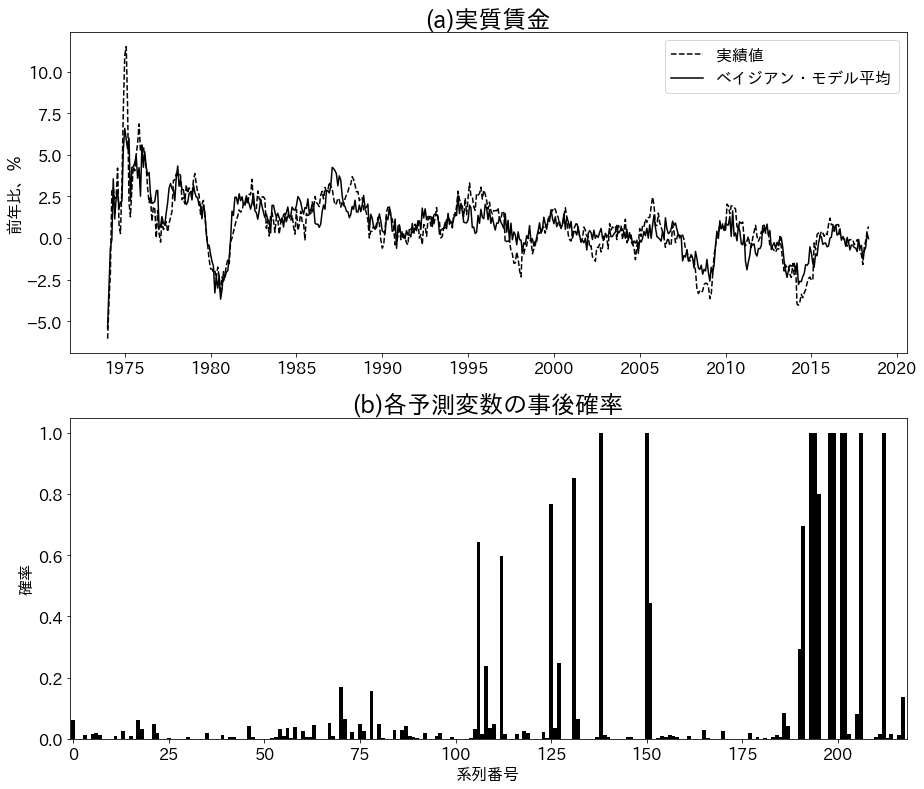

In [ ]:
#####
# グラフの描画
fig = plt.figure(figsize=(15, 13))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.set_title("(a)実質賃金", fontsize=24)
ax1.plot(dti, ms.x130[1:], label="実績値", color="black", linestyle="dashed")
ax1.plot(dti, fitted, label="ベイジアン・モデル平均", color="black")
ax1.legend(loc="upper right", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_ylabel("前年比、％", fontsize=16)
ax2.set_title("(b)各予測変数の事後確率", fontsize=24)
ax2.bar(np.array(range(218)), np.squeeze(inccount), color="black", width=1.0, align="center")
ax2.set_xlim(-1, 218)
ax2.tick_params(labelsize=16)
ax2.set_xlabel("系列番号", fontsize=16)
ax2.set_ylabel("確率", fontsize=16)